# **1. Import Library**
Mengimpor library yang dibutuhkan untuk pengolahan data, pembuatan model, dan evaluasi.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
import scipy.sparse as sp

# **2. Memuat dan Memahami Data**
Memuat dataset preprocessed_dataset.csv untuk memahami struktur data.

In [2]:
# Memuat dataset
anime = pd.read_csv('anime.csv')
ratings = pd.read_csv('rating.csv', nrows=500000)  # Misalnya hanya 500.000 baris

# Menampilkan 5 baris pertama dari dataset anime
print('Data Anime:')
print(anime.head())

# Menampilkan 5 baris pertama dari dataset ratings
print('\nData Rating:')
print(ratings.head())

# Informasi dataset
print('\nInfo Anime:')
print(anime.info())

print('\nInfo Ratings:')
print(ratings.info())


Data Anime:
   anime_id                              name  \
0     32281                    Kimi no Na wa.   
1      5114  Fullmetal Alchemist: Brotherhood   
2     28977                          Gintama°   
3      9253                       Steins;Gate   
4      9969                     Gintama&#039;   

                                               genre   type episodes  rating  \
0               Drama, Romance, School, Supernatural  Movie        1    9.37   
1  Action, Adventure, Drama, Fantasy, Magic, Mili...     TV       64    9.26   
2  Action, Comedy, Historical, Parody, Samurai, S...     TV       51    9.25   
3                                   Sci-Fi, Thriller     TV       24    9.17   
4  Action, Comedy, Historical, Parody, Samurai, S...     TV       51    9.16   

   members  
0   200630  
1   793665  
2   114262  
3   673572  
4   151266  

Data Rating:
   user_id  anime_id  rating
0        1        20      -1
1        1        24      -1
2        1        79      -1
3   

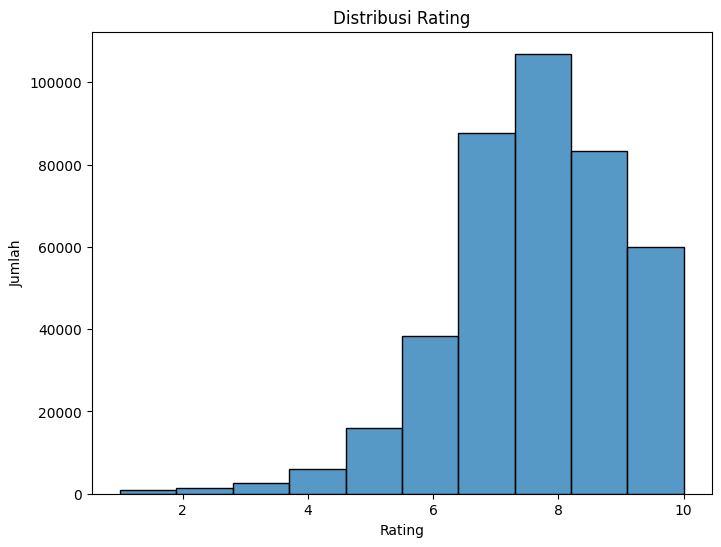

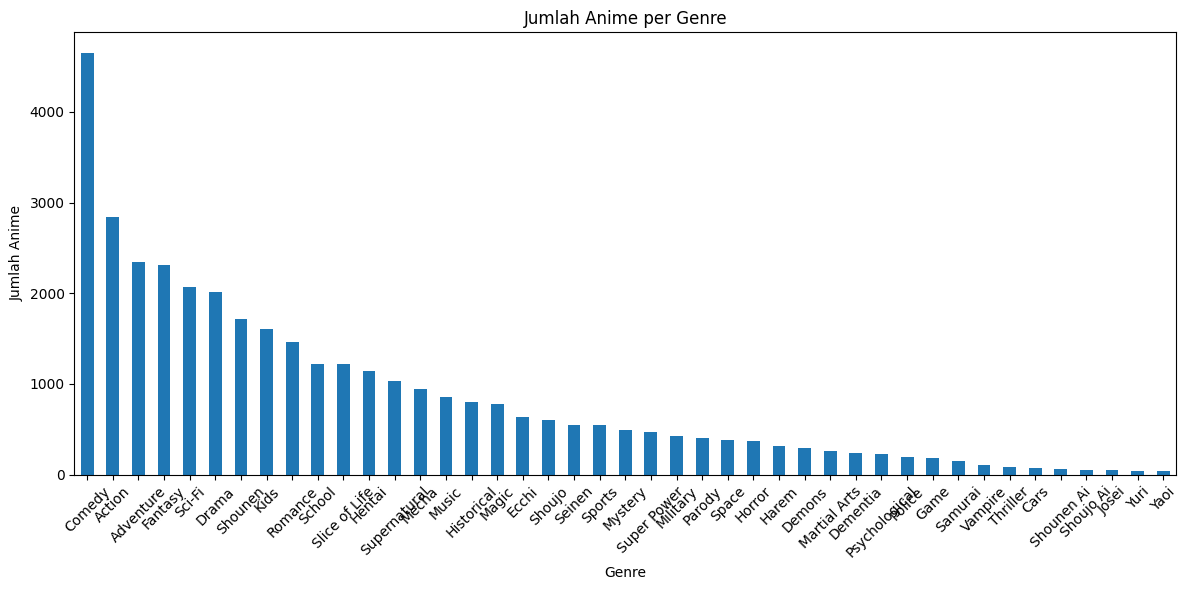

In [3]:
# Menghapus rating -1
ratings_clean = ratings[ratings['rating'] != -1]

plt.figure(figsize=(8, 6))
sns.histplot(ratings_clean['rating'], bins=10, kde=False)
plt.title('Distribusi Rating')
plt.xlabel('Rating')
plt.ylabel('Jumlah')
plt.show()

# Jumlah anime per genre
genres = anime['genre'].dropna().str.split(', ').explode()
genre_counts = genres.value_counts()

plt.figure(figsize=(12, 6))
genre_counts.plot(kind='bar')
plt.title('Jumlah Anime per Genre')
plt.xlabel('Genre')
plt.ylabel('Jumlah Anime')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# **3. Data Preparation untuk Content-based Filtering**
Membersihkan data dan mengubah kolom genre menjadi format yang bisa digunakan untuk menghitung kemiripan.

In [4]:
# Menghapus data dengan genre kosong
anime_clean = anime.dropna(subset=['genre'])

# Menggunakan TF-IDF Vectorizer untuk mengubah teks genre menjadi fitur numerik
tfidf = TfidfVectorizer(token_pattern=r'[^, ]+', stop_words='english')
tfidf_matrix = tfidf.fit_transform(anime_clean['genre'])

cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# 5. Buat mapping dari judul anime ke indeks
indices = pd.Series(anime_clean.index, index=anime_clean['name']).drop_duplicates()
print("Shape of TF-IDF matrix:", tfidf_matrix.shape)

Shape of TF-IDF matrix: (12232, 45)


# **4. Implementasi Content-based Filtering**
Membuat fungsi untuk merekomendasikan anime berdasarkan kemiripan genre.

In [5]:
def get_content_based_recommendations(title, cosine_sim=cosine_sim, anime=anime, top_n=10):

    if title not in anime['name'].values:
        return f"Anime dengan judul '{title}' tidak ditemukan."

    idx = anime[anime['name'] == title].index[0]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:top_n+1]
    anime_indices = [i[0] for i in sim_scores]

    return anime.iloc[anime_indices][['anime_id', 'name']]

print('Rekomendasi untuk "Naruto":')
print(get_content_based_recommendations('Naruto'))

Rekomendasi untuk "Naruto":
      anime_id                                               name
615       1735                                 Naruto: Shippuuden
841         20                                             Naruto
1103     32365  Boruto: Naruto the Movie - Naruto ga Hokage ni...
1343     10075                                        Naruto x UT
1472      8246        Naruto: Shippuuden Movie 4 - The Lost Tower
1573      6325  Naruto: Shippuuden Movie 3 - Hi no Ishi wo Tsu...
2458     19511               Naruto Shippuuden: Sunny Side Battle
2996      6946       Mudazumo Naki Kaikaku: The Legend of Koizumi
7617     21833                               Higenashi Gogejabaru
784      13667         Naruto: Shippuuden Movie 6 - Road to Ninja


# **HEATMAP COSINE SIMILARITY**

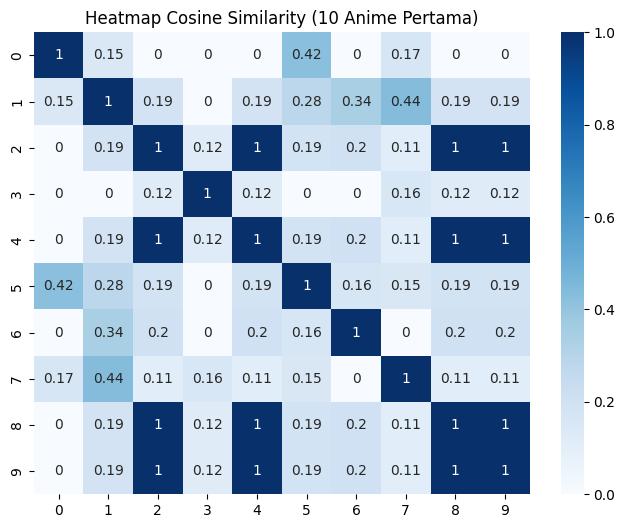

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(cosine_sim[:10, :10], annot=True, cmap='Blues')
plt.title('Heatmap Cosine Similarity (10 Anime Pertama)')
plt.show()

# **5. Data Preparation untuk Collaborative Filtering**
Membuat matriks user-item berdasarkan rating dan mempersiapkan model KNN

In [9]:
user_item_matrix = ratings.pivot(index='user_id', columns='anime_id', values='rating')
user_item_matrix = user_item_matrix.fillna(0)

sparse_matrix = sp.csr_matrix(user_item_matrix.values)

knn = NearestNeighbors(metric='cosine', algorithm='brute')
knn.fit(sparse_matrix)

print("Dimensi user-item matrix:", user_item_matrix.shape)

Dimensi user-item matrix: (5078, 7145)


# **6. Implementasi Collaborative Filtering**
Membuat fungsi untuk merekomendasikan anime berdasarkan rating pengguna lain



In [10]:
def get_collaborative_recommendations(user_id, user_item_matrix=user_item_matrix, knn=knn, anime=anime, top_n=10):

    user_idx = user_item_matrix.index.get_loc(user_id)

    distances, indices = knn.kneighbors(sparse_matrix[user_idx], n_neighbors=11)

    similar_users = user_item_matrix.iloc[indices.flatten()[1:]]
    anime_scores = similar_users.mean(axis=0)
    top_anime = anime_scores.sort_values(ascending=False).head(top_n)
    anime_ids = top_anime.index

    return anime[anime['anime_id'].isin(anime_ids)][['anime_id', 'name']].drop_duplicates()

print('Rekomendasi untuk user_id = 1:')
print(get_collaborative_recommendations(1))

Rekomendasi untuk user_id = 1:
      anime_id                      name
200        121       Fullmetal Alchemist
588       6033           Dragon Ball Kai
724      15451       High School DxD New
804      11757          Sword Art Online
1057     11617           High School DxD
1123      8841   Kore wa Zombie Desu ka?
1263      5277  Sekirei: Pure Engagement
1442     15583               Date A Live
1709      8074    Highschool of the Dead
4444       225            Dragon Ball GT


# **7. Evaluasi**
Mengevaluasi hasil rekomendasi secara kualitatif:
- Evaluasi Content-Based Filtering : Mengecek apakah sistem merekomendasikan anime yang mirip secara konten (misalnya genre) dengan anime input
- Evaluasi Collaborative Filtering : Mengecek apakah anime yang direkomendasikan ke pengguna memiliki rating tinggi dari komunitas pengguna lain

**7.1 Evaluasi Content-Based Filtering**

In [11]:
# Evaluasi Content-based Filtering
def evaluate_content_based(title, anime=anime, cosine_sim=cosine_sim, top_n=10):
    if title not in anime['name'].values:
        print(f"Anime '{title}' tidak ditemukan.")
        return

    input_idx = anime[anime['name'] == title].index[0]
    input_genres = anime.iloc[input_idx]['genre']

    # Ambil rekomendasi
    recommendations = get_content_based_recommendations(title, cosine_sim, anime, top_n)

    # Cek genre rekomendasi
    print(f"Genre anime input '{title}': {input_genres}")
    print("\nRekomendasi dan genrenya:")
    for rec_title in recommendations['name'].values:
        rec_genres = anime[anime['name'] == rec_title]['genre'].values[0]
        print(f"- {rec_title}: {rec_genres}")

# Contoh evaluasi
evaluate_content_based('Naruto')

Genre anime input 'Naruto': Action, Comedy, Martial Arts, Shounen, Super Power

Rekomendasi dan genrenya:
- Naruto: Shippuuden: Action, Comedy, Martial Arts, Shounen, Super Power
- Naruto: Action, Comedy, Martial Arts, Shounen, Super Power
- Boruto: Naruto the Movie - Naruto ga Hokage ni Natta Hi: Action, Comedy, Martial Arts, Shounen, Super Power
- Naruto x UT: Action, Comedy, Martial Arts, Shounen, Super Power
- Naruto: Shippuuden Movie 4 - The Lost Tower: Action, Comedy, Martial Arts, Shounen, Super Power
- Naruto: Shippuuden Movie 3 - Hi no Ishi wo Tsugu Mono: Action, Comedy, Martial Arts, Shounen, Super Power
- Naruto Shippuuden: Sunny Side Battle: Action, Comedy, Martial Arts, Shounen, Super Power
- Mudazumo Naki Kaikaku: The Legend of Koizumi: Comedy, Game, Parody, Seinen
- Higenashi Gogejabaru: Comedy, Fantasy, Kids, Music
- Naruto: Shippuuden Movie 6 - Road to Ninja: Action, Adventure, Martial Arts, Shounen, Super Power


**7.2 Evaluasi Collaborative Filtering**

In [12]:
# Evaluasi Collaborative Filtering
def evaluate_collaborative(user_id, user_item_matrix=user_item_matrix, knn=knn, anime=anime, ratings=ratings, top_n=10):

    recommendations = get_collaborative_recommendations(user_id, user_item_matrix, knn, anime, top_n)

    recommended_ids = recommendations['anime_id'].tolist()
    avg_ratings = ratings[ratings['anime_id'].isin(recommended_ids)].groupby('anime_id')['rating'].mean()

    print(f"Rekomendasi untuk user_id = {user_id}:")
    for i, row in recommendations.iterrows():
        anime_id = row['anime_id']
        name = row['name']
        avg_rating = avg_ratings.get(anime_id, 'Tidak ada rating')
        print(f"- {name}: Rata-rata rating = {avg_rating}")


evaluate_collaborative(1)

Rekomendasi untuk user_id = 1:
- Fullmetal Alchemist: Rata-rata rating = 6.801298701298701
- Dragon Ball Kai: Rata-rata rating = 6.281437125748503
- High School DxD New: Rata-rata rating = 6.6954261954261955
- Sword Art Online: Rata-rata rating = 6.8734177215189876
- High School DxD: Rata-rata rating = 6.473134328358209
- Kore wa Zombie Desu ka?: Rata-rata rating = 6.291153415453527
- Sekirei: Pure Engagement: Rata-rata rating = 6.216346153846154
- Date A Live: Rata-rata rating = 6.381413359148112
- Highschool of the Dead: Rata-rata rating = 6.252189141856392
- Dragon Ball GT: Rata-rata rating = 5.444743935309973


**Content-based Filtering**

Content-based Filtering berfungsi untuk mengukur seberapa relevan genre rekomendasi terhadap anime input

In [13]:
def genre_match_percentage(title, anime=anime, cosine_sim=cosine_sim, top_n=10):
    # Cek apakah judul tersedia
    if title not in anime['name'].values:
        return f"Anime '{title}' tidak ditemukan."

    # Ambil indeks dan genre dari anime input
    input_idx = anime[anime['name'] == title].index[0]
    input_genres = set(str(anime.iloc[input_idx]['genre']).split())

    # Ambil rekomendasi berdasarkan kemiripan konten
    recommendations = get_content_based_recommendations(title, cosine_sim, anime, top_n)

    # Hitung berapa banyak rekomendasi yang memiliki genre mencakup genre input
    matches = 0
    for rec_title in recommendations['name']:
        rec_genres = set(str(anime[anime['name'] == rec_title]['genre'].values[0]).split())
        if input_genres.issubset(rec_genres):
            matches += 1

    return (matches / top_n) * 100

result = genre_match_percentage('Naruto')
print(f"Genre Match Percentage untuk 'Naruto': {result}%")

Genre Match Percentage untuk 'Naruto': 70.0%
